# 1. Set-up

In [1]:
!pip install transformers
!pip install tensorflow

     |████████████████████████████████| 3.5 MB 4.2 MB/s 
     |████████████████████████████████| 596 kB 62.5 MB/s 
     |████████████████████████████████| 895 kB 63.8 MB/s 
     |████████████████████████████████| 6.8 MB 47.2 MB/s 
     |████████████████████████████████| 67 kB 5.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 462 kB 4.3 MB/s 


In [2]:
import os
import re
import json
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

import tensorflow as tf
from tqdm import tqdm
from transformers import BertTokenizer, BertModel, TFBertModel
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score

In [3]:
tf.random.set_seed(1)
np.random.seed(1)

BATCH_SIZE = 32
NUM_EPOCHS = 10
VALID_SPLIT = 0.2
MAX_LENGTH = 39

# 2. Dataset

## 1) 데이터셋 로드

In [4]:
!pip install koco

  Created wheel for koco: filename=koco-0.2.3-py3-none-any.whl size=7362 sha256=a925eb9ef397fb4dac5f36c875fdbbf0e4e55e6f45af5adc0fda268eda3cba96
  Stored in directory: /root/.cache/pip/wheels/fe/32/23/d694980cffc0b144d06f90951b398172b3e2ceeb6e2c980635
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=9b0243c2a2a5a9272e25d802554d0f4f2361b157beec57437bffc98c1118b730
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built koco wget


In [5]:
import koco

train_dev = koco.load_dataset("korean-hate-speech", mode="train_dev")
train, valid = train_dev['train'], train_dev['dev']
train_data = pd.DataFrame.from_dict(train)
valid_data = pd.DataFrame.from_dict(valid)

test = koco.load_dataset("korean-hate-speech", mode="test")
test_data = pd.DataFrame.from_dict(test)

In [ ]:
train_data.head(3)

,comments,contain_gender_bias,bias,hate,news_title
0,(현재 호텔주인 심정) 아18 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속...,False,others,hate,"""밤새 조문 행렬…故 전미선, 동료들이 그리워하는 따뜻한 배우 [종합]"""
1,....한국적인 미인의 대표적인 분...너무나 곱고아름다운모습...그모습뒤의 슬픔을...,False,none,none,"""'연중' 故 전미선, 생전 마지막 미공개 인터뷰…환하게 웃는 모습 '먹먹'[종합]"""
2,"...못된 넘들...남의 고통을 즐겼던 넘들..이젠 마땅한 처벌을 받아야지..,그래...",False,none,hate,"""[단독] 잔나비, 라디오 출연 취소→'한밤' 방송 연기..비판 여론 ing(종합)"""


**✏️ 데이터셋을 보면 현 프로젝트에 필요하지 않은 contain_gender_bias, bias 컬럼이 포함되어 있다.**

## 2) 데이터 전처리 - 필요한 컬럼 추출, 결측치 제거

In [7]:
# 필요한 컬럼만 추출
train_data = train_data.loc[:, ['comments', 'hate']]
# 결측치 제거
train_data.dropna(inplace=True)

In [8]:
train_data.head(3)

,comments,hate
0,(현재 호텔주인 심정) 아18 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속...,hate
1,....한국적인 미인의 대표적인 분...너무나 곱고아름다운모습...그모습뒤의 슬픔을...,none
2,"...못된 넘들...남의 고통을 즐겼던 넘들..이젠 마땅한 처벌을 받아야지..,그래...",hate


In [9]:
# 필요한 컬럼만 추출
valid_data = valid_data.loc[:, ['comments', 'hate']]
# 결측치 제거
valid_data.dropna(inplace=True)

In [10]:
valid_data.head(3)

,comments,hate
0,송중기 시대극은 믿고본다. 첫회 신선하고 좋았다.,none
1,지현우 나쁜놈,offensive
2,알바쓰고많이만들면되지 돈욕심없으면골목식당왜나온겨 기댕기게나하고 산에가서팔어라,hate


In [11]:
# 필요한 컬럼만 추출
test_data = test_data.loc[:, ['comments']]

In [12]:
test_data.head(3)

,comments
0,ㅋㅋㅋㅋ 그래도 조아해주는 팬들 많아서 좋겠다 ㅠㅠ 니들은 온유가 안만져줌 ㅠㅠ
1,둘다 넘 좋다~행복하세요
2,근데 만원이하는 현금결제만 하라고 써놓은집 우리나라에 엄청 많은데


In [13]:
print(train_data.shape, test_data.shape)

(7896, 2) (974, 1)


## 3) 데이터 전처리 - hate 컬럼을 이진 분류 (1, 0)으로 매칭
✏️ hate 컬럼은 hate/offensive/none으로 분류되어 있으므로
hate, offensive => 1,
none => 0 으로 변환

In [14]:
train_data.loc[train_data['hate'] != 'none', 'hate'] = 1
train_data.loc[train_data['hate'] == 'none', 'hate'] = 0
train_data.head(3)

,comments,hate
0,(현재 호텔주인 심정) 아18 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속...,1
1,....한국적인 미인의 대표적인 분...너무나 곱고아름다운모습...그모습뒤의 슬픔을...,0
2,"...못된 넘들...남의 고통을 즐겼던 넘들..이젠 마땅한 처벌을 받아야지..,그래...",1


✏️ hate 컬럼의 1과 0의 분포 비율

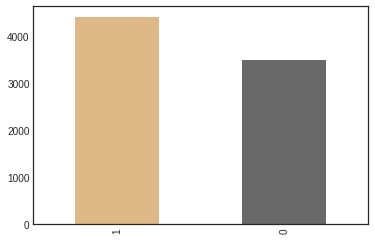

In [15]:
colors = ['burlywood', 'dimgray']
CountStatus = pd.value_counts(train_data['hate'].values, sort=True)
CountStatus.plot.bar('bar', color=colors)

In [16]:
# 검정 데이터에도 같은 작업 수행.
valid_data.loc[valid_data['hate'] != 'none', 'hate'] = 1
valid_data.loc[valid_data['hate'] == 'none', 'hate'] = 0
valid_data.head(3)

,comments,hate
0,송중기 시대극은 믿고본다. 첫회 신선하고 좋았다.,0
1,지현우 나쁜놈,1
2,알바쓰고많이만들면되지 돈욕심없으면골목식당왜나온겨 기댕기게나하고 산에가서팔어라,1


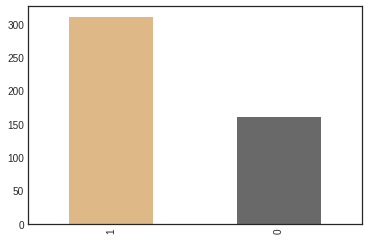

In [17]:
colors = ['burlywood', 'dimgray']
CountStatus = pd.value_counts(valid_data['hate'].values, sort=True)
CountStatus.plot.bar('bar', color=colors)

# 3. 토큰화 및 모델링
✏️ bert_tokenizer() 
- BERT를 사용하기 위해서 BERT 문장 전처리 함수이다. BERT를 사용하기 위해 input_ids, attention_mask, token_type_ids가 필요하다.
- input_ids : 문장을 인덱스 값으로 변환.
- attention_mask : 문장에서 패딩 부분이 어디인지 알려주는 역할을 한다.
- token_type_ids : 여러 문장이 들어 갔을 때 이를 구분하기 위함이다. [0 0 0 0 1 1 1 1 0 0 0 0] 이런 경우 총 3문장임을 알 수 있다.

## 1) bert-base-multilingual-cased
✏️ 토큰화 과정

In [18]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', cache_dir='bert-ckpt', do_lower_case=False)

def bert_tokenizer(sentence, MAX_LENGTH):
  # encode_plus: 필요한 입력 형태로 변환 및 문장 최대 길이 맞추는 역할. 딕셔너리 형태로 출력.
  encoded_dict = tokenizer.encode_plus(
      text = sentence,
      add_special_tokens = True,          # 토큰 시작점과 마지막 지점에 각 각 [CLS], [SEP] 토큰 생성.
      max_length = MAX_LENGTH,            # 문장을 최대 길이 MAX_LENGTH에 맞춘다.
      pad_to_max_length = True,           # 문장이 최대 길이 MAX_LENGTH보다 짧은 경우 패딩 적용.
      return_attention_mask = True        # 어텐션 마스크 생성
  )
  input_id = encoded_dict['input_ids']
  attention_mask = encoded_dict['attention_mask']
  token_type_id = encoded_dict['token_type_ids']

  return input_id, attention_mask, token_type_id

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [19]:
input_ids = []
attention_masks = []
token_type_ids = []
# train_data_labels = []
train_labels_multilingual = []

for train_sentence, train_label in tqdm(zip(train_data['comments'], train_data['hate']), total=len(train_data)):
  try:
    input_id, attention_mask, token_type_id = bert_tokenizer(train_sentence, MAX_LENGTH)

    input_ids.append(input_id)
    attention_masks.append(attention_mask)
    token_type_ids.append(token_type_id)
    train_labels_multilingual.append(train_label)
  except Exception as e:
    print(e)
    pass

train_hate_input_ids = np.array(input_ids, dtype=int)
train_hate_attention_masks = np.array(attention_masks, dtype=int)
train_hate_token_type_ids = np.array(token_type_ids, dtype=int)
# train_hate_inputs = (train_hate_input_ids, train_hate_attention_masks, train_hate_token_type_ids)
# train_data_labels = np.asarray(train_data_labels, dtype=np.int32)

# print("Sentences:{}\nLabels:{}".format(len(train_hate_input_ids), len(train_data_labels)))
train_inputs_multilingual = (train_hate_input_ids, train_hate_attention_masks, train_hate_token_type_ids)
train_labels_multilingual = np.asarray(train_labels_multilingual, dtype=np.int32)

print("Sentences:{}\nLabels:{}".format(len(train_inputs_multilingual), len(train_labels_multilingual)))

  0%|          | 0/7896 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 7896/7896 [00:03<00:00, 2538.40it/s]

Sentences:3
Labels:7896


In [21]:
input_ids = []
attention_masks = []
token_type_ids = []
# train_data_labels = []
valid_labels_multilingual = []

for valid_sentence, valid_label in tqdm(zip(valid_data['comments'], valid_data['hate']), total=len(valid_data)):
  try:
    input_id, attention_mask, token_type_id = bert_tokenizer(valid_sentence, MAX_LENGTH)

    input_ids.append(input_id)
    attention_masks.append(attention_mask)
    token_type_ids.append(token_type_id)
    valid_labels_multilingual.append(valid_label)
  except Exception as e:
    print(e)
    pass

valid_hate_input_ids = np.array(input_ids, dtype=int)
valid_hate_attention_masks = np.array(attention_masks, dtype=int)
valid_hate_token_type_ids = np.array(token_type_ids, dtype=int)
valid_inputs_multilingual = (valid_hate_input_ids, valid_hate_attention_masks, valid_hate_token_type_ids)
valid_labels_multilingual = np.asarray(valid_labels_multilingual, dtype=np.int32)

print("Sentences:{}\nLabels:{}".format(len(valid_inputs_multilingual), len(valid_labels_multilingual)))

  0%|          | 0/471 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 471/471 [00:00<00:00, 2816.45it/s]

Sentences:3
Labels:471


✏️ input_id, attention_mask, token_type_id 형태 확인하기

In [22]:
# 확인
idx = 10

input_id = train_hate_input_ids[idx]
attention_mask = train_hate_attention_masks[idx]
token_type_id = train_hate_token_type_ids[idx]

print("input_id: ", input_id)
print("attention_mask: ", attention_mask)
print("token_type_id: ", token_type_id)
print("tokenizer.decode(input_id): ", tokenizer.decode(input_id))

input_id:  [   101  10150 106249   9730  57362   9008  10622 119353  28911   9365
  14646  59894    136   9294  50472   8996  24974  12030  12508   8931
  40032  35506  77884    119    119    102      0      0      0      0
      0      0      0      0      0      0      0      0      0]
attention_mask:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0]
token_type_id:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
tokenizer.decode(input_id):  [CLS] 10살 차이가 넘을텐데 부부라고? 무슨 내용인지 긍금하네.. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


✏️ Pre-trained model 불러오기 

In [23]:
class TFBertClassifier(tf.keras.Model):
  def __init__(self, model_name, dir_path, num_class):
    super(TFBertClassifier, self).__init__()
    self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
    self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
    self.classifier = tf.keras.layers.Dense(num_class,
                                            kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range),
                                            name='classifier')
    
  def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
    outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
    pooled_output = outputs[1]
    pooled_output = self.dropout(pooled_output, training=training)
    logits = self.classifier(pooled_output)

    return logits

multilingual_model = TFBertClassifier(model_name='bert-base-multilingual-cased',
                             dir_path='bert-ckpt',
                             num_class=2)

Downloading:   0%|          | 0.00/1.01G [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [24]:
optimizer = tf.keras.optimizers.Adam(3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
multilingual_model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=[metric])

In [25]:
model_name = 'multilingual_hate_speech'

es_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=5)

checkpoint_path = os.path.join('./', model_name, 'weights{epoch:04d}.ckpt')
checkpoint_dir = os.path.dirname(checkpoint_path)
latest = tf.train.latest_checkpoint(checkpoint_dir)

if os.path.exists(checkpoint_dir):
  print('{} Directory already exists.\n'.format(checkpoint_dir))
else:
  os.makedirs(checkpoint_dir, exist_ok=True)  
  print('{} Directory create completes.\n'.format(checkpoint_dir))

cp_callback = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1,
                              save_best_only=True, save_weights_only=True)

history_multilingual = multilingual_model.fit(train_inputs_multilingual, train_labels_multilingual,
                        epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_data = (valid_inputs_multilingual, valid_labels_multilingual),
                        callbacks=[es_callback, cp_callback])
print(history_multilingual.history)

./multilingual_hate_speech Directory create completes.

Epoch 1/10
247/247 [==============================] - ETA: 0s - loss: 0.6101 - accuracy: 0.6550
Epoch 1: val_accuracy improved from -inf to 0.75372, saving model to ./multilingual_hate_speech/weights0001.ckpt
247/247 [==============================] - 78s 242ms/step - loss: 0.6101 - accuracy: 0.6550 - val_loss: 0.5178 - val_accuracy: 0.7537
Epoch 2/10
247/247 [==============================] - ETA: 0s - loss: 0.5066 - accuracy: 0.7505
Epoch 2: val_accuracy did not improve from 0.75372
247/247 [==============================] - 49s 197ms/step - loss: 0.5066 - accuracy: 0.7505 - val_loss: 0.8995 - val_accuracy: 0.6285
Epoch 3/10
247/247 [==============================] - ETA: 0s - loss: 0.4001 - accuracy: 0.8199
Epoch 3: val_accuracy did not improve from 0.75372
247/247 [==============================] - 49s 197ms/step - loss: 0.4001 - accuracy: 0.8199 - val_loss: 0.6905 - val_accuracy: 0.7431
Epoch 4/10
247/247 [===================

In [34]:
valid_predict_multilingual = multilingual_model.predict(valid_inputs_multilingual, batch_size=32)
predict_labels_multilingual = np.argmax(valid_predict_multilingual, axis=1)

In [37]:
print('val accuracy:', accuracy_score(valid_labels_multilingual, predict_labels_multilingual))
print('val f1_score:', f1_score(valid_labels_multilingual, predict_labels_multilingual))

val accuracy: 0.7112526539278131
val f1_score: 0.750915750915751


In [38]:
print(classification_report(valid_labels_multilingual, predict_labels_multilingual))

              precision    recall  f1-score   support

           0       0.55      0.81      0.66       160
           1       0.87      0.66      0.75       311

    accuracy                           0.71       471
   macro avg       0.71      0.74      0.70       471
weighted avg       0.76      0.71      0.72       471



In [39]:
def show_history(model_hist):
  plt.figure(figsize=(10, 5))

  plt.subplot(121)
  plt.plot(model_hist.history['loss'], 'b', label='train')
  plt.plot(model_hist.history['val_loss'], 'r', label='val')
  plt.title('Loss')
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.legend(loc='upper left')

  plt.subplot(122)
  plt.plot(model_hist.history['accuracy'], 'b', label='train')
  plt.plot(model_hist.history['val_accuracy'], 'r', label='val')
  plt.title('Accuracy')
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.legend(loc='upper left')

  plt.show();

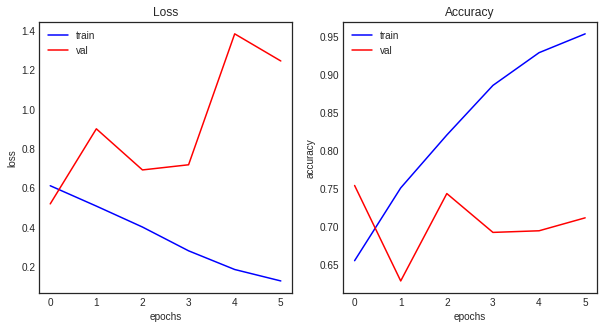

In [40]:
show_history(history_multilingual)

## 2) 'kykim/bert-kor-base' model

In [41]:
kor_tokenizer = BertTokenizer.from_pretrained('kykim/bert-kor-base', cache_dir='kor-bert-ckpt', do_lower_case=False)

def kor_bert_tokenizer(sentence, MAX_LENGTH):
  # encode_plus: 필요한 입력 형태로 변환 및 문장 최대 길이 맞추는 역할. 딕셔너리 형태로 출력.
  encoded_dict = kor_tokenizer.encode_plus(
      text = sentence,
      add_special_tokens = True,          # 토큰 시작점과 마지막 지점에 각 각 [CLS], [SEP] 토큰 생성.
      max_length = MAX_LENGTH,            # 문장을 최대 길이 MAX_LENGTH에 맞춘다.
      pad_to_max_length = True,           # 문장이 최대 길이 MAX_LENGTH보다 짧은 경우 패딩 적용.
      return_attention_mask = True        # 어텐션 마스크 생성
  )
  input_id = encoded_dict['input_ids']
  attention_mask = encoded_dict['attention_mask']
  token_type_id = encoded_dict['token_type_ids']

  return input_id, attention_mask, token_type_id

Downloading:   0%|          | 0.00/80.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/336k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/725 [00:00<?, ?B/s]

In [42]:
input_ids = []
attention_masks = []
token_type_ids = []
train_labels_kor = []

for train_sentence, train_label in tqdm(zip(train_data['comments'], train_data['hate']), total=len(train_data)):
  try:
    input_id, attention_mask, token_type_id = kor_bert_tokenizer(train_sentence, MAX_LENGTH)

    input_ids.append(input_id)
    attention_masks.append(attention_mask)
    token_type_ids.append(token_type_id)
    train_labels_kor.append(train_label)
  except Exception as e:
    print(e)
    pass

train_kor_input_ids = np.array(input_ids, dtype=int)
train_kor_attention_masks = np.array(attention_masks, dtype=int)
train_kor_token_type_ids = np.array(token_type_ids, dtype=int)
train_inputs_kor = (train_kor_input_ids, train_kor_attention_masks, train_kor_token_type_ids)
train_labels_kor = np.asarray(train_labels_kor, dtype=np.int32)

print("Sentences:{}\nLabels:{}".format(len(train_kor_input_ids), len(train_labels_kor)))

  0%|          | 0/7896 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 7896/7896 [00:03<00:00, 2103.92it/s]

Sentences:7896
Labels:7896


In [45]:
input_ids = []
attention_masks = []
token_type_ids = []
valid_labels_kor = []

for valid_sentence, valid_label in tqdm(zip(valid_data['comments'], valid_data['hate']), total=len(valid_data)):
  try:
    input_id, attention_mask, token_type_id = kor_bert_tokenizer(valid_sentence, MAX_LENGTH)

    input_ids.append(input_id)
    attention_masks.append(attention_mask)
    token_type_ids.append(token_type_id)
    valid_labels_kor.append(valid_label)
  except Exception as e:
    print(e)
    pass

valid_kor_input_ids = np.array(input_ids, dtype=int)
valid_kor_attention_masks = np.array(attention_masks, dtype=int)
valid_kor_token_type_ids = np.array(token_type_ids, dtype=int)
valid_inputs_kor = (valid_kor_input_ids, valid_kor_attention_masks, valid_kor_token_type_ids)
valid_labels_kor = np.asarray(valid_labels_kor, dtype=np.int32)

print("Sentences:{}\nLabels:{}".format(len(valid_kor_input_ids), len(valid_labels_kor)))

  0%|          | 0/471 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 471/471 [00:00<00:00, 2987.79it/s]

Sentences:471
Labels:471


In [43]:
class TFBertClassifier(tf.keras.Model):
  def __init__(self, model_name, dir_path, num_class):
    super(TFBertClassifier, self).__init__()
    self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
    self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
    self.classifier = tf.keras.layers.Dense(num_class,
                                            kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range),
                                            name='classifier')
    
  def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
    outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
    pooled_output = outputs[1]
    pooled_output = self.dropout(pooled_output, training=training)
    logits = self.classifier(pooled_output)

    return logits

kor_bert_model = TFBertClassifier(model_name='kykim/bert-kor-base',
                             dir_path='kor-bert-ckpt',
                             num_class=2)

Downloading:   0%|          | 0.00/452M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at kykim/bert-kor-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [44]:
optimizer = tf.keras.optimizers.Adam(3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
kor_bert_model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=[metric])

In [46]:
model_name = 'kor_bert_hate_speech'

es_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=5)

checkpoint_path = os.path.join('./', model_name, 'weights{epoch:04d}.ckpt')
checkpoint_dir = os.path.dirname(checkpoint_path)
latest = tf.train.latest_checkpoint(checkpoint_dir)

if os.path.exists(checkpoint_dir):
  print('{} Directory already exists.\n'.format(checkpoint_dir))
else:
  os.makedirs(checkpoint_dir, exist_ok=True)  
  print('{} Directory create completes.\n'.format(checkpoint_dir))

cp_callback = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1,
                              save_best_only=True, save_weights_only=True)

history_kor_bert = kor_bert_model.fit(train_inputs_kor, train_labels_kor,
                        epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_data=(valid_inputs_kor, valid_labels_kor),
                        callbacks=[es_callback, cp_callback])

print(history_kor_bert.history)

./kor_bert_hate_speech Directory create completes.

Epoch 1/10
247/247 [==============================] - ETA: 0s - loss: 0.5614 - accuracy: 0.7105
Epoch 1: val_accuracy improved from -inf to 0.80892, saving model to ./kor_bert_hate_speech/weights0001.ckpt
247/247 [==============================] - 69s 221ms/step - loss: 0.5614 - accuracy: 0.7105 - val_loss: 0.4155 - val_accuracy: 0.8089
Epoch 2/10
247/247 [==============================] - ETA: 0s - loss: 0.4008 - accuracy: 0.8184
Epoch 2: val_accuracy did not improve from 0.80892
247/247 [==============================] - 46s 185ms/step - loss: 0.4008 - accuracy: 0.8184 - val_loss: 0.6344 - val_accuracy: 0.7431
Epoch 3/10
247/247 [==============================] - ETA: 0s - loss: 0.2363 - accuracy: 0.9020
Epoch 3: val_accuracy did not improve from 0.80892
247/247 [==============================] - 45s 184ms/step - loss: 0.2363 - accuracy: 0.9020 - val_loss: 0.6904 - val_accuracy: 0.7580
Epoch 4/10
247/247 [===========================

In [62]:
valid_predict_kor_bert = kor_bert_model.predict(valid_inputs_kor, batch_size=32)
predict_labels_kor_bert = np.argmax(valid_predict_kor_bert, axis=1)

In [63]:
print('### kykim/bert-kor-base ###')
print('val accuracy:', accuracy_score(valid_labels_kor, predict_labels_kor_bert))
print('val f1_score:', f1_score(valid_labels_kor, predict_labels_kor_bert))
print(classification_report(valid_labels_kor, predict_labels_kor_bert))

### kykim/bert-kor-base ###
val accuracy: 0.8046709129511678
val f1_score: 0.8391608391608392
              precision    recall  f1-score   support

           0       0.66      0.87      0.75       160
           1       0.92      0.77      0.84       311

    accuracy                           0.80       471
   macro avg       0.79      0.82      0.80       471
weighted avg       0.83      0.80      0.81       471



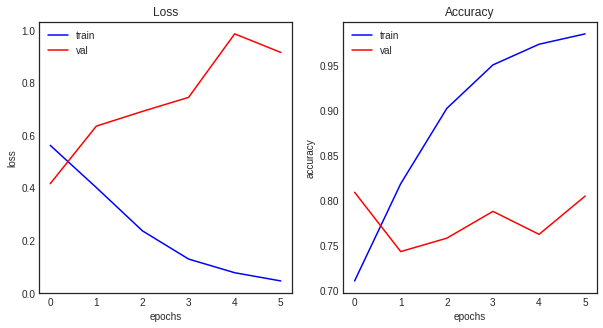

In [51]:
show_history(history_kor_bert)

# 4. 모델 저장
## 1) bert-base-multilingual-cased

In [ ]:
# 저장된 모델 불러오기 (1)
multilingual_loaded_model = TFBertClassifier(model_name='bert-base-multilingual-cased',
                             dir_path='bert-ckpt',
                             num_class=2)

checkpoint_path = '/content/multilingual_hate_speech'
latest = tf.train.latest_checkpoint('/content/multilingual_hate_speech')

multilingual_loaded_model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=[metric])

multilingual_loaded_model.load_weights(latest)

multilingual_loaded_model.fit(train_inputs_multilingual, train_labels_multilingual,
                        epochs=2, batch_size=BATCH_SIZE, validation_split=VALID_SPLIT)

## 2) kykim/bert-kor-base

In [ ]:
# 저장된 모델 불러오기
kor_bert_loaded_model = TFBertClassifier(model_name='kykim/bert-kor-base',
                             dir_path='bert-ckpt',
                             num_class=2)

checkpoint_path = '/content/kor_bert_hate_speech'
latest = tf.train.latest_checkpoint('/content/kor_bert_hate_speech')

kor_bert_loaded_model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=[metric])

kor_bert_loaded_model.load_weights(latest)

kor_bert_loaded_model.fit(train_inputs_kor, train_labels_kor,
                        epochs=2, batch_size=BATCH_SIZE, validation_split=VALID_SPLIT)

Downloading:   0%|          | 0.00/725 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/452M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at kykim/bert-kor-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/2
198/198 [==============================] - 56s 212ms/step - loss: 0.7131 - accuracy: 0.6041 - val_loss: 0.6907 - val_accuracy: 0.5696
Epoch 2/2
198/198 [==============================] - 39s 198ms/step - loss: 0.6789 - accuracy: 0.5948 - val_loss: 0.6560 - val_accuracy: 0.6184


# 5. 테스트 데이터로 Predict
## 1) multilingual_hate_speech model

In [52]:
input_ids = []
attention_masks = []
token_type_ids = []
test_data_labels = []

for test_sentence in tqdm(test_data['comments']):
  try:
    input_id, attention_mask, token_type_id = bert_tokenizer(test_sentence, MAX_LENGTH)

    input_ids.append(input_id)
    attention_masks.append(attention_mask)
    token_type_ids.append(token_type_id)
  except Exception as e:
    print(e)
    pass

test_hate_input_ids = np.array(input_ids, dtype=int)
test_hate_attention_masks = np.array(attention_masks, dtype=int)
test_hate_token_type_ids = np.array(token_type_ids, dtype=int)
test_inputs_multilingual = (test_hate_input_ids, test_hate_attention_masks, test_hate_token_type_ids)

  0%|          | 0/974 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 974/974 [00:00<00:00, 2988.57it/s]


In [53]:
test_predict_multilingual = kor_bert_model.predict(test_inputs_multilingual, batch_size=32)

In [54]:
# multilingual model
predict_labels_multilingual = np.argmax(test_predict_multilingual, axis=1)

## 2) kykim/bert-kor-base

In [55]:
input_ids = []
attention_masks = []
token_type_ids = []
test_data_labels = []

for test_sentence in tqdm(test_data['comments']):
  try:
    input_id, attention_mask, token_type_id = bert_tokenizer(test_sentence, MAX_LENGTH)

    input_ids.append(input_id)
    attention_masks.append(attention_mask)
    token_type_ids.append(token_type_id)
  except Exception as e:
    print(e)
    pass

test_hate_input_ids = np.array(input_ids, dtype=int)
test_hate_attention_masks = np.array(attention_masks, dtype=int)
test_hate_token_type_ids = np.array(token_type_ids, dtype=int)
test_inputs_kor_bert = (test_hate_input_ids, test_hate_attention_masks, test_hate_token_type_ids)

  0%|          | 0/974 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 974/974 [00:00<00:00, 2981.99it/s]


In [56]:
test_predict_kor_bert = kor_bert_model.predict(test_inputs_kor_bert, batch_size=32)

In [57]:
# kor_bert_model
predict_labels_kor_bert = np.argmax(test_predict_kor_bert, axis=1)

In [58]:
result = pd.DataFrame(index=range(0, 974), columns=['Comment', 'multilingual_model', 'kor_bert_model'])
for i in range(974):
  result.iloc[i, 0] = test_data['comments'].iloc[i]
  result.iloc[i, 1] = predict_labels_multilingual[i]
  result.iloc[i, 2] = predict_labels_kor_bert[i]

In [60]:
pd.set_option('display.max_colwidth', -1)
result.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,Comment,multilingual_model,kor_bert_model
0,ㅋㅋㅋㅋ 그래도 조아해주는 팬들 많아서 좋겠다 ㅠㅠ 니들은 온유가 안만져줌 ㅠㅠ,1,1
1,둘다 넘 좋다~행복하세요,1,1
2,근데 만원이하는 현금결제만 하라고 써놓은집 우리나라에 엄청 많은데,1,1
3,원곡생각하나도 안나고 러블리즈 신곡나온줄!!! 너무 예쁘게 잘봤어요,1,1
4,장현승 얘도 참 이젠 짠하다...,1,1
5,신선하게 웃긴다ㅋㅋㅋ역시 동엽신~~!! 장소연님은 진짜 조선족인가 착각할정도로 말투가 리얼하네요,1,1
6,누군데 얘네?,1,1
7,"하자 인생들 모아다가 방송에 내보내고, 덜 하자가 교정해서 장사 풀리게 해주는 감동 스토리 백하자의 골목식당. 호텔 말고 그냥 하자 거리를 하나 열어서 거기다 하자 인생들 교화소를 만들지... 왜 저러고 살까...",1,1
8,진짜 라디오 스타 노래한거 보세요 홍진영은비비지도 못함,1,1
9,"쑈 하지마라 짜식아!음주 1번은 실수, 2번은 고의, 3번은 인간쓰레기다.슬금슬금 기어나올 생각말고 하던대로 그냥 조용히 살어라! 잠재적 살인마.",1,1
